In [23]:
import tensorflow as tf
import os 
from keras.models import Sequential, model_from_config
from keras.layers import Dense, Conv2D, Conv2DTranspose, Input, Flatten, BatchNormalization, Lambda, Reshape
from keras.models import Sequential, Model
from keras.layers import Multiply, Add
from keras.layers import LeakyReLU
from keras.activations import selu
import matplotlib.pyplot as plt

from keras import backend as K

In [24]:
image_dir = "C:/Users/Дмитрий/Desktop/colorfaces"
images = [os.path.join(image_dir, image) for image in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, image))]

# Проверим, что список images содержит правильные пути к файлам
print(len(images))

8204


In [25]:
#preprocessing 
image_size = 64

def preprocess(image):
  image = tf.io.read_file(image)
  image = tf.io.decode_jpeg(image)
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, (image_size, image_size))
  image = image/255.0
  image = tf.reshape(image, shape=(image_size, image_size, 3))
  return image

In [26]:
batch_size = 128

training_dataset = tf.data.Dataset.from_tensor_slices(images)
training_dataset = training_dataset.map(preprocess)
training_dataset = training_dataset.shuffle(1000).batch(batch_size)

In [27]:
len(training_dataset)

65

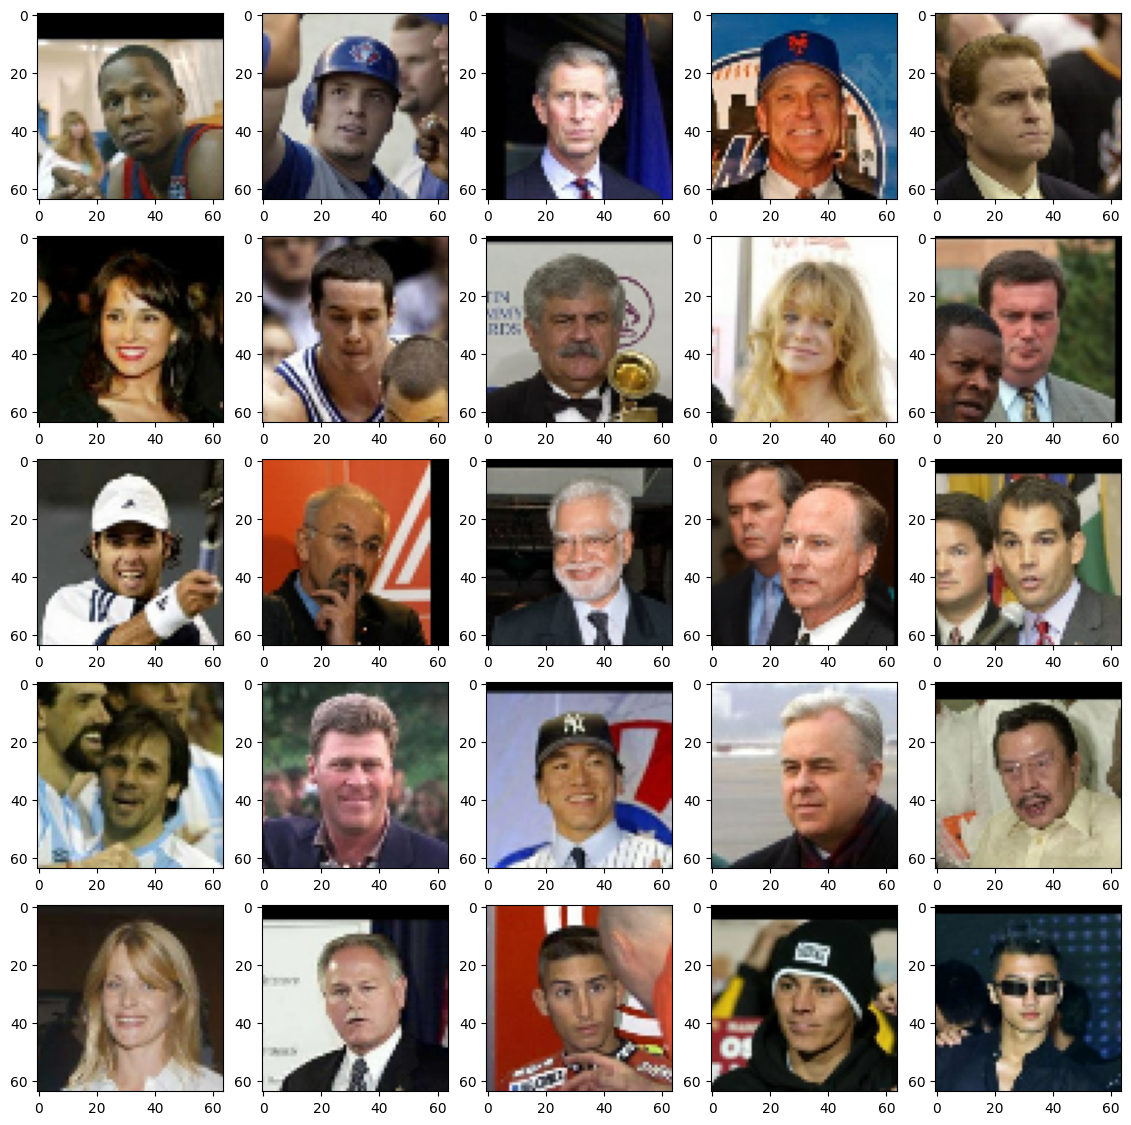

In [28]:
fig, axes = plt.subplots(5,5, figsize = (14,14))
sample = training_dataset.unbatch().take(25)
sample = [image for image in sample]

idx = 0
for row in range(5):
  for column in range(5):
    axes[row, column].imshow(sample[idx])
    idx+=1

In [29]:
#Модель
latent_dim = 32

In [30]:
K.clear_session()

In [31]:
encoder_input = Input(shape=(64, 64 ,3))

x = Conv2D(16, (5,5), activation=LeakyReLU(0.02), strides=1, padding = 'same')(encoder_input)
x = BatchNormalization()(x)

filter_size = [8,16,32,64]
for i in filter_size:
  x = Conv2D(i, (5,5), activation=LeakyReLU(0.02), strides=1, padding='same')(x)
  x = BatchNormalization()(x)

x = Flatten()(x)
x = Dense(64, activation = selu)(x)
encoder_output = BatchNormalization()(x)

#sampling layer
mu = Dense(latent_dim)(encoder_output)
log_var = Dense(latent_dim)(encoder_output)

epsilon = K.random_normal(shape = (tf.shape(mu)[0], tf.shape(mu)[1]))
sigma = tf.exp(0.5*log_var)

z_eps = Multiply()([sigma, epsilon])
z = Add()([mu, z_eps])

encoder = Model(encoder_input, outputs = [mu, log_var, z], name = 'encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 64, 64, 16)           1216      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 64, 64, 16)           64        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 conv2d_1 (Conv2D)           (None, 64, 64, 8)            3208      ['batch_normalization[0]

In [32]:
# build the decoder

decoder = Sequential()
decoder.add(Dense(1024, activation = selu, input_shape = (latent_dim, )))
decoder.add(BatchNormalization())

decoder.add(Dense(8192, activation = selu))
decoder.add(Reshape((4,4,512)))

decoder.add(Conv2DTranspose(256, (5,5), activation = LeakyReLU(0.02), strides = 2, padding = 'same'))
decoder.add(BatchNormalization())

decoder.add(Conv2DTranspose(128, (5,5), activation = LeakyReLU(0.02), strides = 2, padding = 'same'))
decoder.add(BatchNormalization())

decoder.add(Conv2DTranspose(64, (5,5), activation = LeakyReLU(0.02), strides = 2, padding = 'same'))
decoder.add(BatchNormalization())

decoder.add(Conv2DTranspose(32, (5,5), activation = LeakyReLU(0.02), strides = 2, padding = 'same'))
decoder.add(BatchNormalization())

decoder.add(Conv2DTranspose(3, (5,5), activation = "sigmoid", strides = 1, padding = 'same'))
decoder.add(BatchNormalization())

decoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 1024)              33792     
                                                                 
 batch_normalization_6 (Bat  (None, 1024)              4096      
 chNormalization)                                                
                                                                 
 dense_4 (Dense)             (None, 8192)              8396800   
                                                                 
 reshape (Reshape)           (None, 4, 4, 512)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 8, 8, 256)         3277056   
 anspose)                                                        
                                                                 
 batch_normalization_7 (Bat  (None, 8, 8, 256)         1

In [33]:
# make loss function 
# vae loss = reconstruction loss + KL div

def reconstruction_loss(y, y_pred):
    return tf.reduce_mean(tf.square(y - y_pred))

def kl_loss(mu, log_var):
    loss = -0.5 * tf.reduce_mean(1 + log_var - tf.square(mu) - tf.exp(log_var))
    return loss

def vae_loss(y_true, y_pred, mu, log_var):
    return reconstruction_loss(y_true, y_pred) + (1 / (64*64)) * kl_loss(mu, log_var)

In [34]:

# conbine encoder and decoder
mu, log_var, z = encoder(encoder_input)
reconstructed = decoder(z)
model = Model(encoder_input, reconstructed, name ="vae")
loss = kl_loss(mu, log_var)
model.add_loss(loss)
model.summary()

Model: "vae"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 encoder (Functional)        [(None, 32),                 1685397   ['input_1[0][0]']             
                              (None, 32),                 6                                       
                              (None, 32)]                                                         
                                                                                                  
 sequential (Sequential)     (None, 64, 64, 3)            1279150   ['encoder[0][2]']             
                                                          3                                     

In [35]:
# make a function to save images while learning
def save_images(model, epoch, step, input_):
    prediction = model.predict(input_)
    fig, axes = plt.subplots(5,5, figsize = (14,14))
    idx = 0
    for row in range(5):
        for column in range(5):
            image = prediction[idx] * 255
            image = image.astype("int32")
            axes[row, column].imshow(image)
            axes[row, column].axis("off")
            idx+=1
    output_path = "output/"
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    plt.savefig(output_path + "Epoch_{:04d}_step_{:04d}.jpg".format(epoch, step))
    plt.close()

In [36]:
# train vae

from keras.optimizers import Adam

random_vector = tf.random.normal(shape = (25, latent_dim,))
save_images(decoder, 0, 0, random_vector)

mse_losses = []
kl_losses = []

optimizer = Adam(0.0001, 0.5)
epochs = 100

for epoch in range(1, epochs + 1):
    print("Epoch: ", epoch)
    for step, training_batch in enumerate(training_dataset):
        with tf.GradientTape() as tape:
            reconstructed = model(training_batch)
            y_true = tf.reshape(training_batch, shape = [-1])
            y_pred = tf.reshape(reconstructed, shape = [-1])
            
            mse_loss = reconstruction_loss(y_true, y_pred)
            mse_losses.append(mse_loss.numpy())
            
            kl = sum(model.losses)
            kl_losses.append(kl.numpy())
            
            train_loss = 0.01 * kl + mse_loss
            
            grads = tape.gradient(train_loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))
            
            if step % 10 == 0:
                save_images(decoder, epoch, step, random_vector)
            print("Epoch: %s - Step: %s - MSE loss: %s - KL loss: %s" % (epoch, step, mse_loss.numpy(), kl.numpy()))

1/1 [==============================] - 0s 384ms/step
Epoch:  1
1/1 [==============================] - 0s 332ms/step
Epoch: 1 - Step: 0 - MSE loss: 0.09208258 - KL loss: 0.00017631662
Epoch: 1 - Step: 1 - MSE loss: 0.09567624 - KL loss: 0.00011759542
Epoch: 1 - Step: 2 - MSE loss: 0.09147218 - KL loss: 7.475652e-05
Epoch: 1 - Step: 3 - MSE loss: 0.092764676 - KL loss: 5.855487e-05
Epoch: 1 - Step: 4 - MSE loss: 0.09634169 - KL loss: 5.441317e-05
Epoch: 1 - Step: 5 - MSE loss: 0.093475856 - KL loss: 5.2013915e-05
Epoch: 1 - Step: 6 - MSE loss: 0.09108391 - KL loss: 5.5873323e-05
Epoch: 1 - Step: 7 - MSE loss: 0.09038032 - KL loss: 5.9201586e-05
Epoch: 1 - Step: 8 - MSE loss: 0.0893723 - KL loss: 8.1508566e-05
Epoch: 1 - Step: 9 - MSE loss: 0.09424659 - KL loss: 0.000122903
1/1 [==============================] - 0s 247ms/step
Epoch: 1 - Step: 10 - MSE loss: 0.09013963 - KL loss: 0.00022237832
Epoch: 1 - Step: 11 - MSE loss: 0.08946327 - KL loss: 0.0004141653
Epoch: 1 - Step: 12 - MSE loss